In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


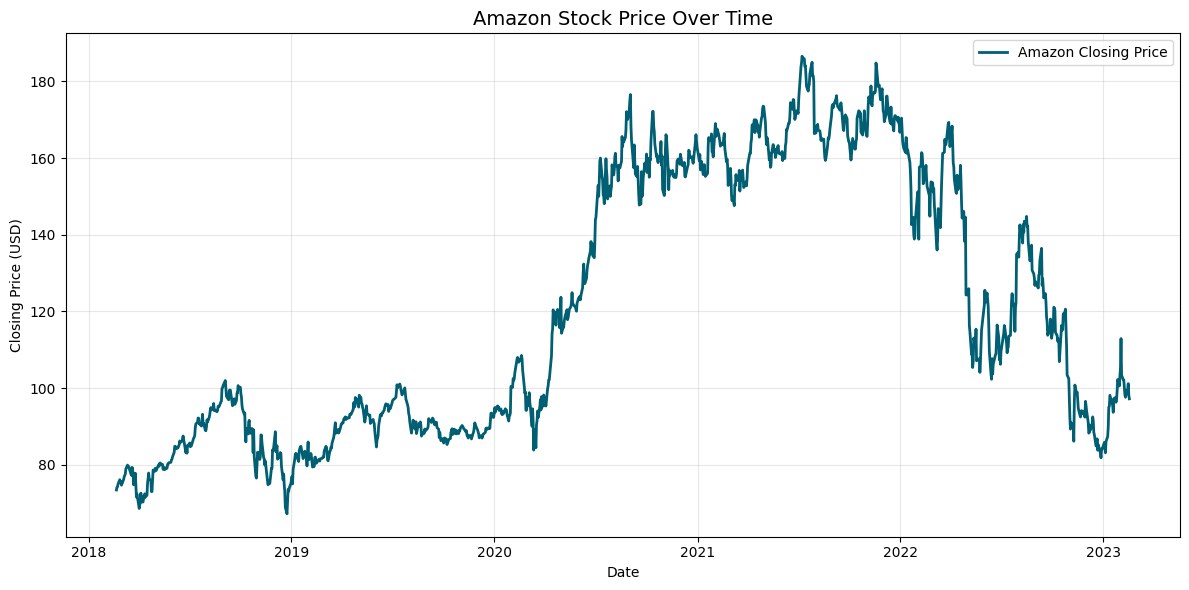

ADF Test p-value: 0.45297105465166737
KPSS Test p-value: 0.01
ADF after Differencing p-value: 0.0
KPSS after Differencing p-value: 0.1


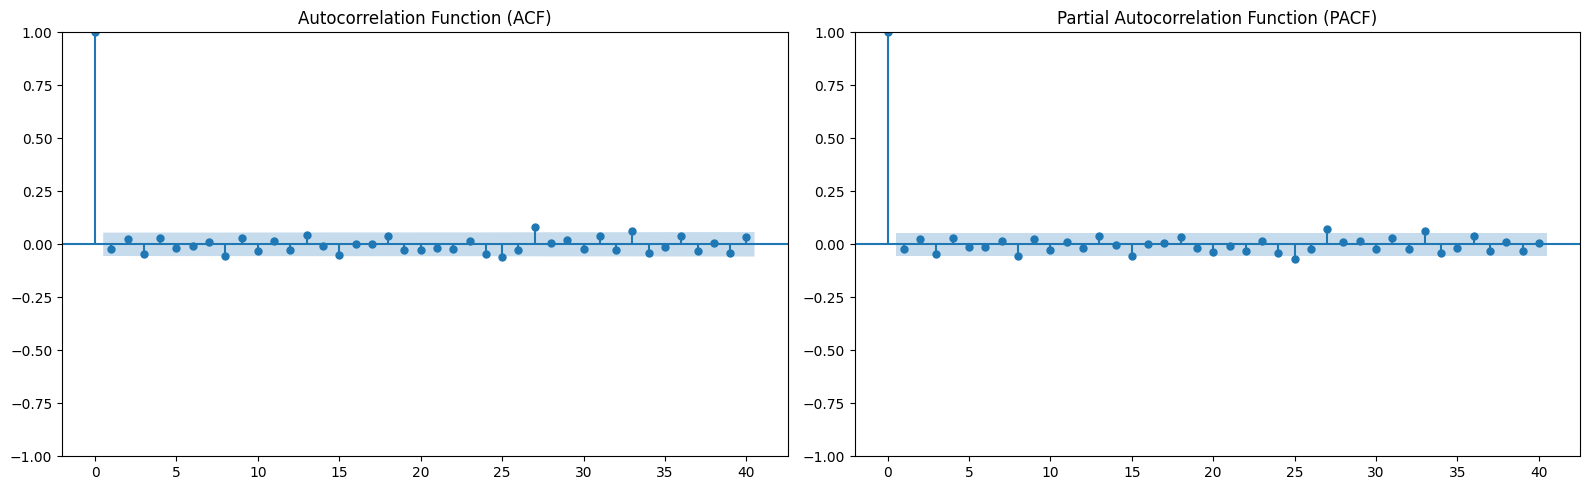

Best ARIMA Order (p,d,q): (2, 1, 2)
Evaluation Metrics for Last 24 Days:
MAE : 2.93
RMSE: 4.22
MAPE: 2.85 %


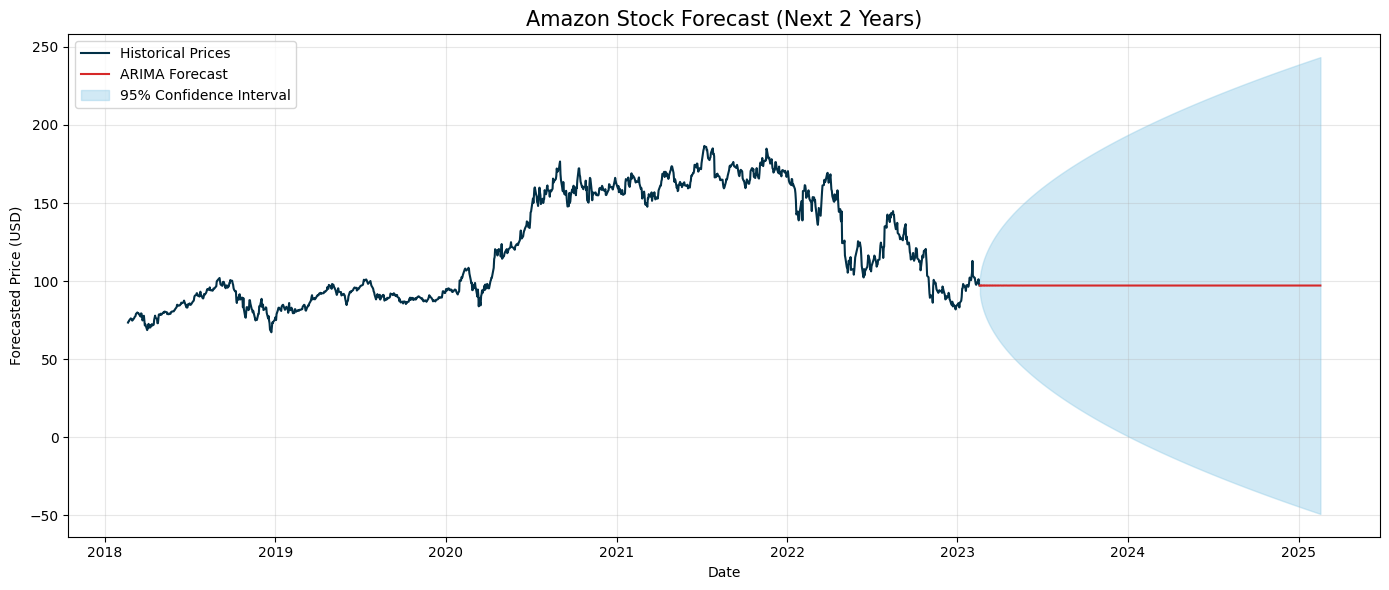

In [11]:
# =====================================
# Unified Time Series Forecasting Imports
# =====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")


# ==========================================
# 1. Load and Visualize Amazon Stock Prices
# ==========================================
amazon_df = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /AMZN.csv")
amazon_df['Date'] = pd.to_datetime(amazon_df['Date'])
amazon_df.set_index('Date', inplace=True)

# Extract closing prices
amzn_close = amazon_df[['Close']]

# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(amzn_close, color='#005f73', linewidth=2, label='Amazon Closing Price')
plt.title('Amazon Stock Price Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =======================================
# 2. Check Stationarity (ADF & KPSS Test)
# =======================================
adf_p = adfuller(amzn_close['Close'])[1]
kpss_p = kpss(amzn_close['Close'], regression='c', nlags='auto')[1]
print("ADF Test p-value:", adf_p)
print("KPSS Test p-value:", kpss_p)

# =================================================
# 3. Apply Differencing and Recheck Stationarity
# =================================================
amzn_diff = amzn_close.diff().dropna()

# Post-differencing stationarity check
adf_diff_p = adfuller(amzn_diff['Close'])[1]
kpss_diff_p = kpss(amzn_diff['Close'], regression='c', nlags='auto')[1]
print("ADF after Differencing p-value:", adf_diff_p)
print("KPSS after Differencing p-value:", kpss_diff_p)

# ====================================
# 4. Plot ACF and PACF for Model Info
# ====================================
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(amzn_diff, lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(amzn_diff, lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()

# ===============================================
# 5. Grid Search for Optimal ARIMA(p,d,q) Model
# ===============================================
lowest_aic = np.inf
best_params = None
best_model = None

for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(amzn_close['Close'], order=(p, 1, q)).fit()
            if model.aic < lowest_aic:
                lowest_aic = model.aic
                best_params = (p, 1, q)
                best_model = model
        except:
            continue

print("Best ARIMA Order (p,d,q):", best_params)

# ====================================================
# 6. Forecasting the Next 730 Days (Approx. 2 Years)
# ====================================================
forecast_result = best_model.get_forecast(steps=730)
forecast_mean = forecast_result.predicted_mean
forecast_bounds = forecast_result.conf_int()

last_obs_date = amzn_close.index[-1]
future_index = pd.date_range(start=last_obs_date + pd.Timedelta(days=1), periods=730, freq='D')

# =======================================================
# 7. Backtest Using the Last 24 Days (Train/Test Split)
# =======================================================
test_days = 24
train_series = amzn_close[:-test_days]
test_series = amzn_close[-test_days:]

# Fit model on training set
train_model = ARIMA(train_series['Close'], order=best_params).fit()
test_forecast = train_model.get_forecast(steps=test_days)
test_preds = test_forecast.predicted_mean

# ======================================
# 8. Forecast Evaluation Metrics Report
# ======================================
true_vals = test_series['Close'].values
pred_vals = test_preds.values

mae = mean_absolute_error(true_vals, pred_vals)
rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
mape = mean_absolute_percentage_error(true_vals, pred_vals)

print("Evaluation Metrics for Last 24 Days:")
print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape * 100, 2), "%")

# ===============================================
# 9. Plot Full Forecast with Confidence Interval
# ===============================================
plt.figure(figsize=(14, 6))
plt.plot(amzn_close.index, amzn_close['Close'], label='Historical Prices', color='#023047')
plt.plot(future_index, forecast_mean, label='ARIMA Forecast', color='#d62828')
plt.fill_between(future_index,
                 forecast_bounds.iloc[:, 0],
                 forecast_bounds.iloc[:, 1],
                 color='#8ecae6', alpha=0.4, label='95% Confidence Interval')
plt.title('Amazon Stock Forecast (Next 2 Years)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Forecasted Price (USD)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**RNN Model**

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0962 - val_loss: 0.0114
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

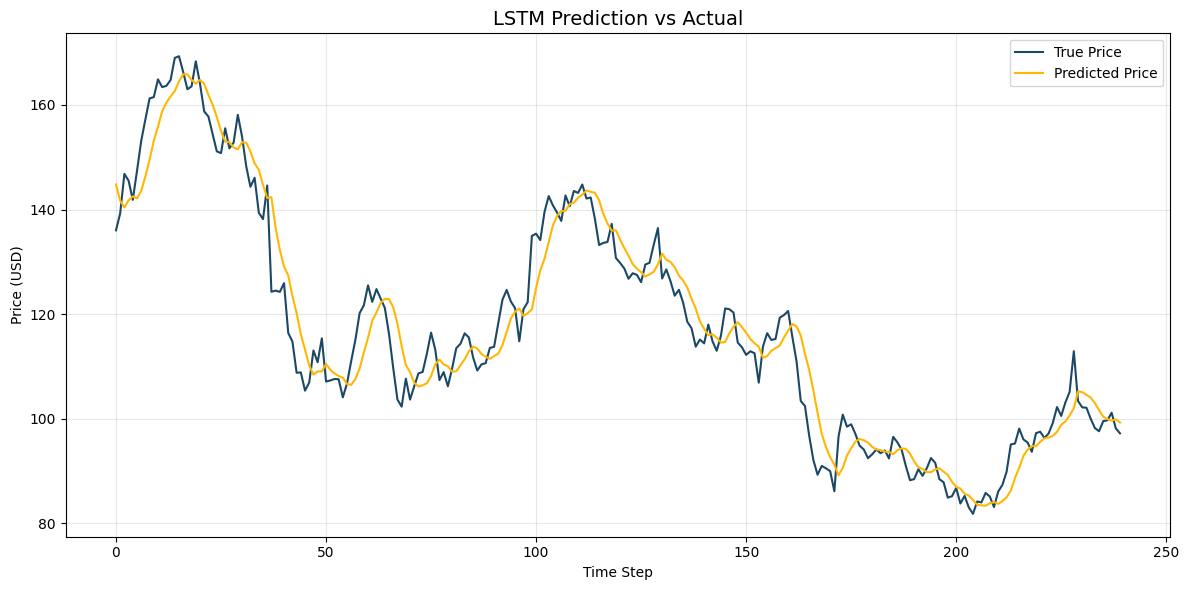

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM Performance Metrics:
MAE  : 4.2212
RMSE : 5.3415
MAPE : 0.0364


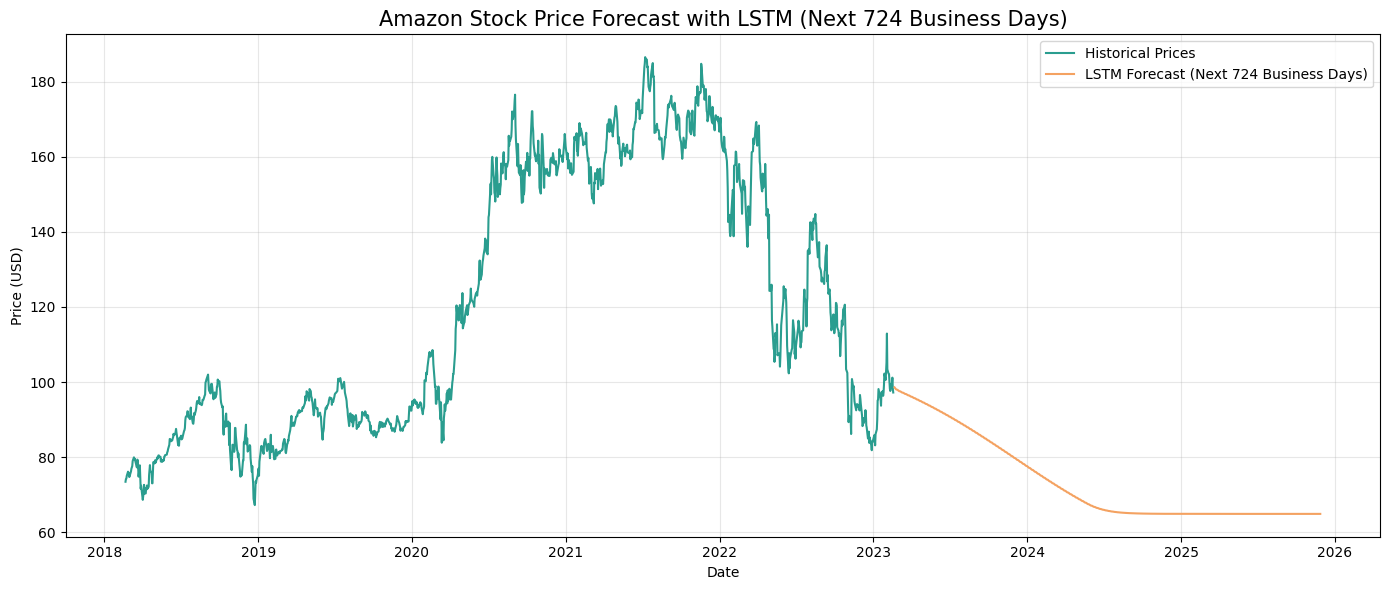

In [12]:
# =====================================
# 2. Load and Preprocess Stock Data
# =====================================
df_amzn = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /AMZN.csv")
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])
df_amzn.set_index('Date', inplace=True)
price_data = df_amzn[['Close']].copy()

# Normalize closing prices
scaler = MinMaxScaler()
price_data['Close'] = scaler.fit_transform(price_data[['Close']])

# =====================================
# 3. Create Input Sequences for LSTM
# =====================================
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_len = 60
X, y = create_sequences(price_data['Close'].values, sequence_len)
X = X.reshape((X.shape[0], X.shape[1], 1))

# =====================================
# 4. Train-Test Split (80/20)
# =====================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# =====================================
# 5. Build and Train LSTM Model
# =====================================
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# =====================================
# 6. Plot Actual vs Predicted Prices
# =====================================
def plot_predictions(model, X_test, y_test, title="LSTM"):
    preds = model.predict(X_test)
    true_vals = scaler.inverse_transform(y_test.reshape(-1, 1))
    pred_vals = scaler.inverse_transform(preds)

    plt.figure(figsize=(12, 6))
    plt.plot(true_vals, label='True Price', color='#1b4965')
    plt.plot(pred_vals, label='Predicted Price', color='#ffb703')
    plt.title(f'{title} Prediction vs Actual', fontsize=14)
    plt.xlabel('Time Step')
    plt.ylabel('Price (USD)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_predictions(model, X_test, y_test)

# =====================================
# 7. Evaluate Model Performance
# =====================================
pred_scaled = model.predict(X_test)
true_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_actual = scaler.inverse_transform(pred_scaled).flatten()

mae = mean_absolute_error(true_actual, predicted_actual)
rmse = np.sqrt(mean_squared_error(true_actual, predicted_actual))
mape = mean_absolute_percentage_error(true_actual, predicted_actual)

print("LSTM Performance Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.4f}")

# =====================================
# 8. Forecast Future Prices (724 Days)
# =====================================
def forecast_future(model, recent_data, forecast_days=724, seq_len=60):
    last_seq = recent_data[-seq_len:].reshape(1, seq_len, 1)
    forecast = []

    for _ in range(forecast_days):
        next_val = model.predict(last_seq, verbose=0)[0][0]
        forecast.append(next_val)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_val]]], axis=1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

forecast_days = 724  # Updated to forecast 724 business days
future_prices = forecast_future(model, price_data['Close'].values, forecast_days, sequence_len)

# =====================================
# 9. Plot Historical + Future Forecast
# =====================================
forecast_dates = pd.date_range(start=price_data.index[-1] + pd.DateOffset(days=1), periods=forecast_days, freq='B')

plt.figure(figsize=(14, 6))
plt.plot(price_data.index, scaler.inverse_transform(price_data['Close'].values.reshape(-1, 1)),
         label='Historical Prices', color='#2a9d8f')
plt.plot(forecast_dates, future_prices, label='LSTM Forecast (Next 724 Business Days)', color='#f4a261')
plt.title('Amazon Stock Price Forecast with LSTM (Next 724 Business Days)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.2375 - val_loss: 0.0245
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0088 - val_loss: 0.0021
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 6.7380e-04 - val_loss: 0.0017
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 6.6439e-04 - val_loss: 0.0016
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 7.2908e-04 - val_loss: 0.0018
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.4381e-04 - val_loss: 0.0016
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.8691e-04 - val_loss: 0.0014
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.0917e-04 - val_loss: 0.0014
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.8320e-04 - val_loss: 0.0014
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 5.4607e-04 - val_loss: 0.0013
Epoch 12/50
30/30 ━━━━━━━━━━━━━

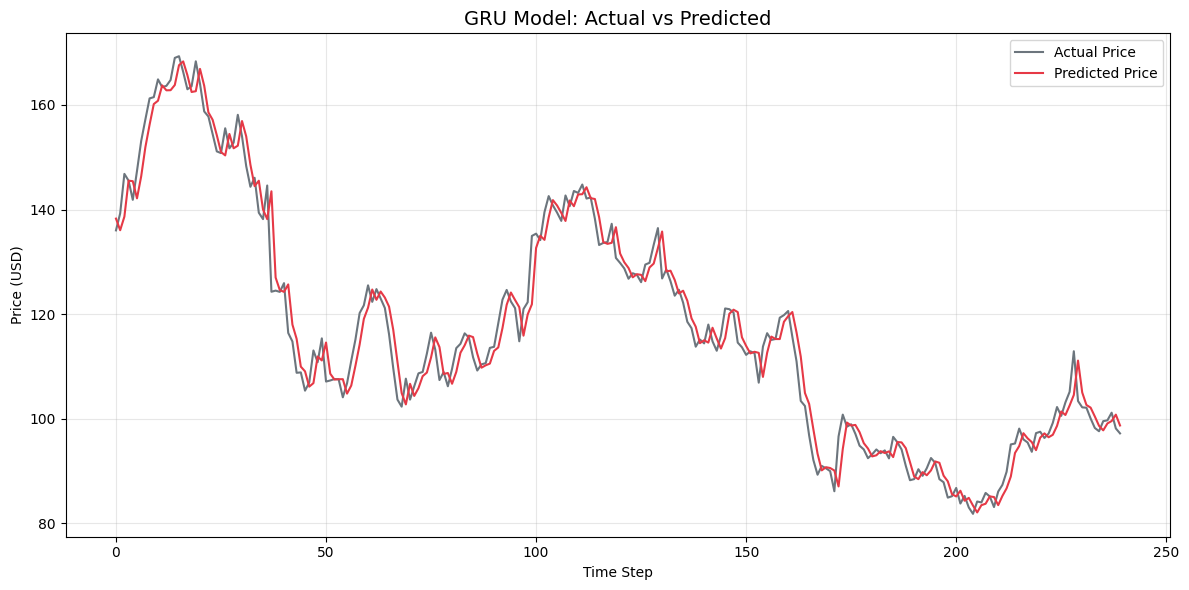

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
GRU Model Evaluation Metrics:
MAE  : 2.8564
RMSE : 3.7536
MAPE : 0.0246


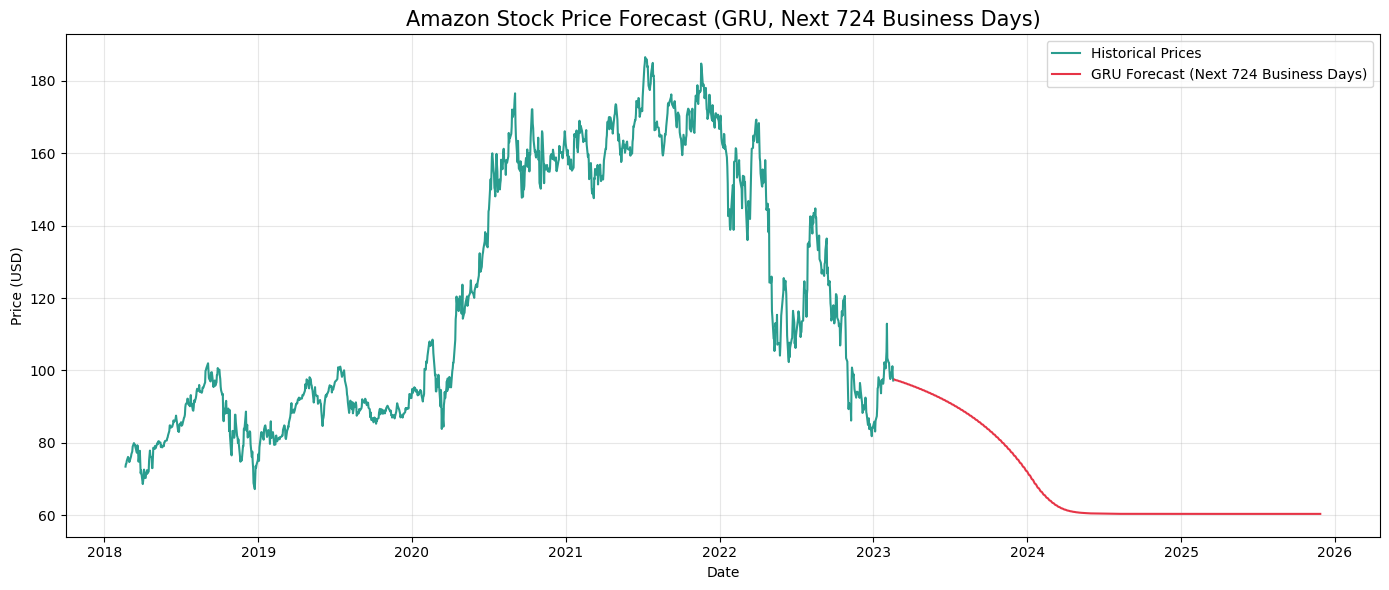

In [13]:
# =====================================
# 2. Load and Normalize Stock Data
# =====================================
df_amzn = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /AMZN.csv")
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])
df_amzn.set_index('Date', inplace=True)

price_data = df_amzn[['Close']].copy()

scaler = MinMaxScaler()
price_data['Close'] = scaler.fit_transform(price_data[['Close']])

# =====================================
# 3. Create Input Sequences for GRU
# =====================================
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_len = 60
X, y = create_sequences(price_data['Close'].values, sequence_len)
X = X.reshape((X.shape[0], X.shape[1], 1))

# =====================================
# 4. Split Data into Train/Test Sets
# =====================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# =====================================
# 5. Build and Train GRU Model
# =====================================
gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# =====================================
# 6. Plot Actual vs Predicted Prices
# =====================================
def plot_predictions(model, X_test, y_test, label="GRU"):
    preds = model.predict(X_test)
    true_vals = scaler.inverse_transform(y_test.reshape(-1, 1))
    pred_vals = scaler.inverse_transform(preds)

    plt.figure(figsize=(12, 6))
    plt.plot(true_vals, label='Actual Price', color='#6c757d')         # slate gray
    plt.plot(pred_vals, label='Predicted Price', color='#e63946')      # dark red
    plt.title(f'{label} Model: Actual vs Predicted', fontsize=14)
    plt.xlabel('Time Step')
    plt.ylabel('Price (USD)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_predictions(gru_model, X_test, y_test)

# =====================================
# 7. Evaluate GRU Model Performance
# =====================================
scaled_preds = gru_model.predict(X_test)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_prices = scaler.inverse_transform(scaled_preds).flatten()

mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

print("GRU Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.4f}")

# =====================================
# 8. Forecast Future Prices (724 Days)
# =====================================
def forecast_future(model, recent_data, forecast_days=724, seq_len=60):
    last_seq = recent_data[-seq_len:].reshape(1, seq_len, 1)
    forecast = []

    for _ in range(forecast_days):
        next_val = model.predict(last_seq, verbose=0)[0][0]
        forecast.append(next_val)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_val]]], axis=1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

forecast_days = 724
future_forecast = forecast_future(gru_model, price_data['Close'].values, forecast_days, sequence_len)

# =====================================
# 9. Plot Historical + Future Forecast
# =====================================
forecast_dates = pd.date_range(start=price_data.index[-1] + pd.DateOffset(days=1), periods=forecast_days, freq='B')

plt.figure(figsize=(14, 6))
plt.plot(price_data.index, scaler.inverse_transform(price_data['Close'].values.reshape(-1, 1)),
         label='Historical Prices', color='#2a9d8f')                   # sea green
plt.plot(forecast_dates, future_forecast,
         label='GRU Forecast (Next 724 Business Days)', color='#e63446')  # dark red
plt.title('Amazon Stock Price Forecast (GRU, Next 724 Business Days)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()